In [1]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from joblib import Parallel, delayed
from matplotlib.lines import Line2D
from pandas.tseries.offsets import MonthEnd
from scipy.optimize import minimize
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error as root_mse
from tqdm import tqdm

os.makedirs("output", exist_ok=True)

# Données

In [2]:
model_data = pd.read_parquet("data/model_data.parquet")
model_data_njl = pd.read_parquet("data/model_data_njl.parquet")
model_data_njl_mdp = pd.read_parquet("data/model_data_njl_nmdp.parquet")
nuances_order = ["Far right", "Right", "Center", "Left", "Far left", "Other"]

In [3]:
presi_dates = [
    "26/04/1981", "10/05/1981",
    "24/04/1988", "08/05/1988",
    "23/04/1995", "07/05/1995",
    "21/04/2002", "05/05/2002",
    "22/04/2007", "06/05/2007",
    "22/04/2012", "06/05/2012",
    "21/04/2017", "07/05/2017",
    "10/04/2022", "24/04/2022"]
presi_months = pd.to_datetime(presi_dates, dayfirst=True).to_period('M').drop_duplicates()

legi_dates = [
    "14/06/1981", "21/06/1981",
    "16/03/1986",
    "05/06/1988", "11/06/1988",
    "21/03/1993", "28/03/1993",
    "25/05/1997", "01/06/1997",
    "09/06/2002", "16/06/2002",
    "10/06/2007", "17/06/2007",
    "10/06/2012", "17/06/2012",
    "11/06/2017", "18/06/2017",
    "12/06/2022", "19/06/2022",
    "29/06/2024", "06/07/2024"]
legi_months = pd.to_datetime(legi_dates, dayfirst=True).to_period('M').drop_duplicates()

europ_dates = [
    "17/06/1984",
    "18/06/1989",
    "12/06/1994",
    "13/06/1999",
    "13/06/2004",
    "07/06/2009",
    "25/05/2014",
    "26/05/2019",
    "09/06/2024"]
europ_months = pd.to_datetime(europ_dates, dayfirst=True).to_period('M').drop_duplicates()

main_elec_dates = presi_dates + legi_dates + europ_dates
main_elec_months = pd.to_datetime(main_elec_dates, dayfirst=True).to_period('M').drop_duplicates().sort_values()

def add_shaded_periods(ax_list, periods, color, alpha):
    start_period = None
    for i, period in enumerate(periods):
        if start_period is None:
            start_period = period
        is_last = (i == len(periods) - 1)
        is_gap = (not is_last and periods[i + 1] != period + 1)
        if is_last or is_gap:
            end_period = period
            start = start_period.to_timestamp()
            end = (end_period + MonthEnd(1)).to_timestamp()
            for ax in ax_list:
                ax.axvspan(start, end, color=color, alpha=alpha)
            start_period = None

In [4]:
outcome = "quotes_share"

In [5]:
cutoff = pd.Period('2009-12', freq='M')

# 1. Modèle
## 1.1. Estimation

In [6]:
def compute_y_pred(
    df,
    n, alpha, beta, gamma, theta,
    delta_pre_5, delta_pre_4, delta_pre_3, delta_pre_2, delta_pre_1, delta_pre_0,
    lambda_1, lambda_2):
    
    baseline = (
        beta * (1 - n * alpha - theta) * df["na_share"] +
        gamma * (1 - n * alpha - theta) * df["pres_votes_share"] +
        theta * df["government"])

    y_pred = (
        alpha +
        df["inter_dum"] * baseline +
        df["pre_5"] * ((1 - delta_pre_5) * baseline + delta_pre_5 * df["pres_poll_result"]) +
        df["pre_4"] * ((1 - delta_pre_4) * baseline + delta_pre_4 * df["pres_poll_result"]) +
        df["pre_3"] * ((1 - delta_pre_3) * baseline + delta_pre_3 * df["pres_poll_result"]) +
        df["pre_2"] * ((1 - delta_pre_2) * baseline + delta_pre_2 * df["pres_poll_result"]) +
        df["pre_1"] * ((1 - delta_pre_1) * baseline + delta_pre_1 * df["pres_poll_result"]) +
        df["pre_0"] * ((1 - delta_pre_0) * baseline + delta_pre_0 * df["pres_poll_result"]) +
        df["post_dum"] * (
            (1 - n * alpha - lambda_1 - lambda_2) * df["pres_votes_share"] +
            lambda_1 * df["r2_rank_1"] +
            lambda_2 * df["r2_rank_2"]))

    return y_pred

In [7]:
def objective(params, data_opt, y_opt):
    alpha = params[0]
    beta = params[1]
    gamma = 1 - beta
    theta = params[2]
    delta_pre_5, delta_pre_4, delta_pre_3, delta_pre_2, delta_pre_1, delta_pre_0 = params[3:9]
    lambda_1, lambda_2 = params[9:11]

    y_pred = compute_y_pred(
        data_opt,
        n, alpha, beta, gamma, theta,
        delta_pre_5, delta_pre_4, delta_pre_3, delta_pre_2, delta_pre_1, delta_pre_0,
        lambda_1, lambda_2)

    return root_mse(y_opt, y_pred)

# Initial guess for the coefficients: alpha, beta, theta, delta_pre_5 to delta_pre_0, lambda_1 and lambda_2
initial_guess = [0.01, 0.7, 0.2, 0.9, 0.85, 0.8, 0.7, 0.5, 0.2, 0.15, 0.1]

# Bounds: all coefficients between 0 and 1
bounds = [(0, 1)] * 11

# Constraints: increasing poll weights during electoral campaigns
constraints = [
    {"type": "ineq", "fun": lambda x: x[4] - x[3]},  # delta_pre_5 > delta_pre_4
    {"type": "ineq", "fun": lambda x: x[5] - x[4]},  # delta_pre_4 > delta_pre_3
    {"type": "ineq", "fun": lambda x: x[6] - x[5]},  # delta_pre_3 > delta_pre_2
    {"type": "ineq", "fun": lambda x: x[7] - x[6]},  # delta_pre_2 > delta_pre_1
    {"type": "ineq", "fun": lambda x: x[8] - x[7]},  # delta_pre_1 > delta_pre_0
]

# Number of political nuances
n = len(model_data_njl_mdp['political_alignment'].unique())

In [8]:
data_opt = model_data_njl_mdp[model_data_njl_mdp["month"] <= cutoff][
    ["inter_dum", "pre_5", "pre_4", "pre_3", "pre_2", "pre_1", "pre_0", "post_dum", 
     "na_share", "pres_votes_share", "government", "pres_poll_result", "r2_rank_1", "r2_rank_2"]]

y_opt = model_data_njl_mdp[model_data_njl_mdp["month"] <= cutoff][outcome]

# Set constraints=constraints to use the conditions on delta_pre_x
result = minimize(objective, initial_guess, args=(data_opt, y_opt), bounds=bounds, constraints=[], method='SLSQP')

if result.success:
    alpha, beta, theta, delta_pre_5, delta_pre_4, delta_pre_3, delta_pre_2, delta_pre_1, delta_pre_0, lambda_1, lambda_2 = result.x
    gamma = 1 - beta

    print(f"Optimal alpha: {alpha:.5f}")
    print(f"Optimal beta: {beta:.5f}")
    print(f"Optimal gamma: {gamma:.5f}")
    print(f"Optimal theta: {theta:.5f}")
    print(f"Optimal delta_pre_5: {delta_pre_5:.5f}")
    print(f"Optimal delta_pre_4: {delta_pre_4:.5f}")
    print(f"Optimal delta_pre_3: {delta_pre_3:.5f}")
    print(f"Optimal delta_pre_2: {delta_pre_2:.5f}")
    print(f"Optimal delta_pre_1: {delta_pre_1:.5f}")
    print(f"Optimal delta_pre_0: {delta_pre_0:.5f}")
    print(f"Optimal lambda_1: {lambda_1:.5f}")
    print(f"Optimal lambda_2: {lambda_2:.5f}")
else:
    print("Optimization failed:", result.message)

Optimal alpha: 0.00000
Optimal beta: 0.77926
Optimal gamma: 0.22074
Optimal theta: 0.03987
Optimal delta_pre_5: 0.13775
Optimal delta_pre_4: 0.00000
Optimal delta_pre_3: 0.00000
Optimal delta_pre_2: 0.02851
Optimal delta_pre_1: 0.09567
Optimal delta_pre_0: 0.18614
Optimal lambda_1: 0.26140
Optimal lambda_2: 0.17426


## 1.2. Bootstrapping

In [9]:
# Bootstrapping (on months instead of observations to respect compositionnality)
n_bootstraps = 5000

def run_bootstrap_iteration(seed, data):
    np.random.seed(seed)
    sampled_block_ids = np.random.choice(n_blocks, size=n_blocks, replace=True)
    sampled_row_indices = np.concatenate([
        np.arange(block_id * 6, block_id * 6 + 6) for block_id in sampled_block_ids
    ])
    boot_data = data.iloc[sampled_row_indices].reset_index(drop=True)
    boot_data = boot_data[[
        outcome,
        "political_alignment", "inter_dum", "pre_5", "pre_4", "pre_3", "pre_2", "pre_1", "pre_0", "post_dum",
        "na_share", "pres_votes_share", "government", "pres_poll_result", "r2_rank_1", "r2_rank_2"]]
    boot_y = boot_data[outcome]

    result = minimize(objective, initial_guess, args=(boot_data, boot_y), bounds=bounds, constraints=[], method='SLSQP')
    
    if result.success:
        alpha, beta, theta, delta_pre_5, delta_pre_4, delta_pre_3, delta_pre_2, delta_pre_1, delta_pre_0, lambda_1, lambda_2 = result.x
        gamma = 1 - beta
        return {
            "alpha": alpha,
            "beta": beta,
            "gamma": gamma,
            "theta": theta,
            "delta_pre_5": delta_pre_5,
            "delta_pre_4": delta_pre_4,
            "delta_pre_3": delta_pre_3,
            "delta_pre_2": delta_pre_2,
            "delta_pre_1": delta_pre_1,
            "delta_pre_0": delta_pre_0,
            "lambda_1": lambda_1,
            "lambda_2": lambda_2
        }
    else:
        return None

In [10]:
data = model_data_njl_mdp[model_data_njl_mdp["month"] <= cutoff][[outcome, 
    "political_alignment", "inter_dum", "pre_5", "pre_4", "pre_3", "pre_2", "pre_1", "pre_0", "post_dum", 
    "na_share", "pres_votes_share", "government", "pres_poll_result", "r2_rank_1", "r2_rank_2"]]

n_blocks = len(data) // 6

results = Parallel(n_jobs=-1)(
    delayed(run_bootstrap_iteration)(seed, data)
    for seed in tqdm(range(n_bootstraps), desc="Bootstrapping")
)

# Filter out failed runs
bootstrap_results = [r for r in results if r is not None]

Bootstrapping: 100%|██████████| 5000/5000 [04:21<00:00, 19.12it/s]


In [11]:
# Using a one-tail approach for pvalues as coefficients are bounded by zero
bootstrap_df = pd.DataFrame(bootstrap_results)
pval = (bootstrap_df <= 0).sum() / len(bootstrap_df)
original_coeffs = pd.Series({
    "alpha": alpha,
    "beta": beta,
    "gamma": gamma,
    "theta": theta,
    "delta_pre_5": delta_pre_5,
    "delta_pre_4": delta_pre_4,
    "delta_pre_3": delta_pre_3,
    "delta_pre_2": delta_pre_2,
    "delta_pre_1": delta_pre_1,
    "delta_pre_0": delta_pre_0,
    "lambda_1": lambda_1,
    "lambda_2": lambda_2})

bootstrap_df = bootstrap_df.describe(percentiles=[0.025, 0.5, 0.975]).T
bootstrap_df["pval"] = pval
bootstrap_df["coeff"] = original_coeffs
bootstrap_df = bootstrap_df.drop(columns = ['count', 'min', '50%', 'max'])
cols = ["coeff"] + [col for col in bootstrap_df.columns if col != "coeff"]
bootstrap_df = bootstrap_df[cols]
bootstrap_df.style.format("{:.4f}")

## 1.3. Performances
### Sur les données de référence

In [12]:
y_pred = compute_y_pred(
    data_opt,
    n, alpha, beta, gamma, theta,
    delta_pre_5, delta_pre_4, delta_pre_3, delta_pre_2, delta_pre_1, delta_pre_0,
    lambda_1, lambda_2)

r2 = r2_score(y_opt, y_pred)
mr = (y_opt - y_pred).mean()
rmspe = root_mse(y_opt, y_pred)

print(f"R2: {100*r2:.3f}%")
print(f"MR: {100*mr:.5f}%")
print(f"RMSPE: {rmspe:.5f}")
print("")
print(f"Negative outcomes: {(y_pred < 0).sum()}")
print(f"Positive outcomes: {(y_pred > 1).sum()}")

outcome_data = pd.DataFrame({
    "month": model_data_njl_mdp["month"],
    "y_pred": y_pred})
outcome_data = outcome_data[outcome_data["month"] <= cutoff].groupby(['month']).sum()
bad_outcomes = ((outcome_data < 1 - 0.00005) | (outcome_data > 1 + 0.00005)).sum().iloc[0]
print(f"Wrong compositional outcomes: {bad_outcomes}")
if bad_outcomes > 0:
    print(outcome_data[(outcome_data["y_pred"] < 1 - 0.00005) | (outcome_data["y_pred"] > 1 + 0.00005)])

R2: 91.321%
MR: -0.00004%
RMSPE: 0.06915

Negative outcomes: 0
Positive outcomes: 0
Wrong compositional outcomes: 6
           y_pred
month            
1981-05  1.000056
1981-06  1.000056
1988-05  0.999944
1988-06  0.999944
2007-05  1.000056
2007-06  1.000056


### Performance on the full dataset (up to 2025, with *Médiapart*, without journals)

In [13]:
y_pred = compute_y_pred(
    model_data_njl,
    n, alpha, beta, gamma, theta,
    delta_pre_5, delta_pre_4, delta_pre_3, delta_pre_2, delta_pre_1, delta_pre_0,
    lambda_1, lambda_2)

y_opt = model_data_njl[outcome]

r2 = r2_score(y_opt, y_pred)
mr = (y_opt - y_pred).mean()
rmspe = root_mse(y_opt, y_pred)

print(f"R2: {100*r2:.3f}%")
print(f"MR: {100*mr:.5f}%")
print(f"RMSPE: {rmspe:.5f}")
print("")
print(f"Negative outcomes: {(y_pred < 0).sum()}")
print(f"Positive outcomes: {(y_pred > 1).sum()}")

outcome_data = pd.DataFrame({
    "month": model_data_njl["month"],
    "y_pred": y_pred
}).groupby(['month']).sum()
bad_outcomes = ((outcome_data < 1 - 0.00005) | (outcome_data > 1 + 0.00005)).sum().iloc[0]
print(f"Wrong compositional outcomes: {bad_outcomes}")
if bad_outcomes > 0:
    print(outcome_data[(outcome_data["y_pred"] < 1 - 0.00005) | (outcome_data["y_pred"] > 1 + 0.00005)])

R2: 88.898%
MR: 0.00001%
RMSPE: 0.07317

Negative outcomes: 0
Positive outcomes: 0
Wrong compositional outcomes: 8
           y_pred
month            
1981-05  1.000056
1981-06  1.000056
1988-05  0.999944
1988-06  0.999944
2007-05  1.000056
2007-06  1.000056
2022-05  0.999887
2022-06  0.999887


### Performance on the full dataset, with journals

In [14]:
y_pred = compute_y_pred(
    model_data,
    n, alpha, beta, gamma, theta,
    delta_pre_5, delta_pre_4, delta_pre_3, delta_pre_2, delta_pre_1, delta_pre_0,
    lambda_1, lambda_2)

y_opt = model_data[outcome]

r2 = r2_score(y_opt, y_pred)
mr = (y_opt - y_pred).mean()
rmspe = root_mse(y_opt, y_pred)

print(f"R2: {100*r2:.3f}%")
print(f"MR: {100*mr:.5f}%")
print(f"RMSPE: {rmspe:.5f}")
print("")
print(f"Negative outcomes: {(y_pred < 0).sum()}")
print(f"Positive outcomes: {(y_pred > 1).sum()}")

outcome_data = pd.DataFrame({
    "month": model_data["month"],
    "journal": model_data["journal"],
    "y_pred": y_pred
}).groupby(['month', 'journal']).sum()
bad_outcomes = ((outcome_data < 1 - 0.00005) | (outcome_data > 1 + 0.00005)).sum().iloc[0]
print(f"Wrong compositional outcomes: {bad_outcomes}")
if bad_outcomes > 0:
    print(outcome_data[(outcome_data["y_pred"] < 1 - 0.00005) | (outcome_data["y_pred"] > 1 + 0.00005)])

R2: 86.532%
MR: 0.00003%
RMSPE: 0.08002

Negative outcomes: 0
Positive outcomes: 0
Wrong compositional outcomes: 26
                      y_pred
month   journal             
1981-05 Le Figaro   1.000056
        Le Monde    1.000056
1981-06 Le Figaro   1.000056
        Le Monde    1.000056
1988-05 Le Figaro   0.999944
        Le Monde    0.999944
1988-06 Le Figaro   0.999944
        Le Monde    0.999944
2007-05 La Croix    1.000056
        Le Figaro   1.000056
        Le Monde    1.000056
        Libération  1.000056
2007-06 La Croix    1.000056
        Le Figaro   1.000056
        Le Monde    1.000056
        Libération  1.000056
2022-05 La Croix    0.999887
        Le Figaro   0.999887
        Le Monde    0.999887
        Libération  0.999887
        Médiapart   0.999887
2022-06 La Croix    0.999887
        Le Figaro   0.999887
        Le Monde    0.999887
        Libération  0.999887
        Médiapart   0.999887


# 2. Écarts à la norme de représentativité selon les nuances politiques

In [15]:
model_data_njl['y_norm'] = compute_y_pred(
    model_data_njl,
    n, alpha, beta, gamma, theta,
    delta_pre_5, delta_pre_4, delta_pre_3, delta_pre_2, delta_pre_1, delta_pre_0,
    lambda_1, lambda_2)
plot_data = model_data_njl.copy()
plot_data['abs_residuals'] = 100 * (plot_data[outcome] - plot_data['y_norm'])

## 2.1. Résidus moyens
Ils sont intéressants pour connaître la direction des écarts à la norme de représentativité, mais attention, rien n'assure qu'ils soient significatifs ! Il faut mobiliser la régression des résidus pour cela.

In [16]:
first_period = (
    plot_data[plot_data["month"] <= cutoff]
    .groupby('political_alignment')["abs_residuals"].mean()
    .rename("1981-2009")
)

second_period = (
    plot_data[plot_data["month"] > cutoff]
    .groupby('political_alignment')["abs_residuals"].mean()
    .rename("2010-2025")
)

both_periods = (
    plot_data.groupby('political_alignment')["abs_residuals"].mean()
    .rename("1981-2025")
)

mr_table = pd.concat([first_period, second_period, both_periods], axis=1)
mr_table = mr_table.reindex(nuances_order)
mr_table.style.format("{:.4f}")

## 2.2. Observations vs. prédictions

In [17]:
plot_data['month'] = plot_data['month'].dt.to_timestamp()

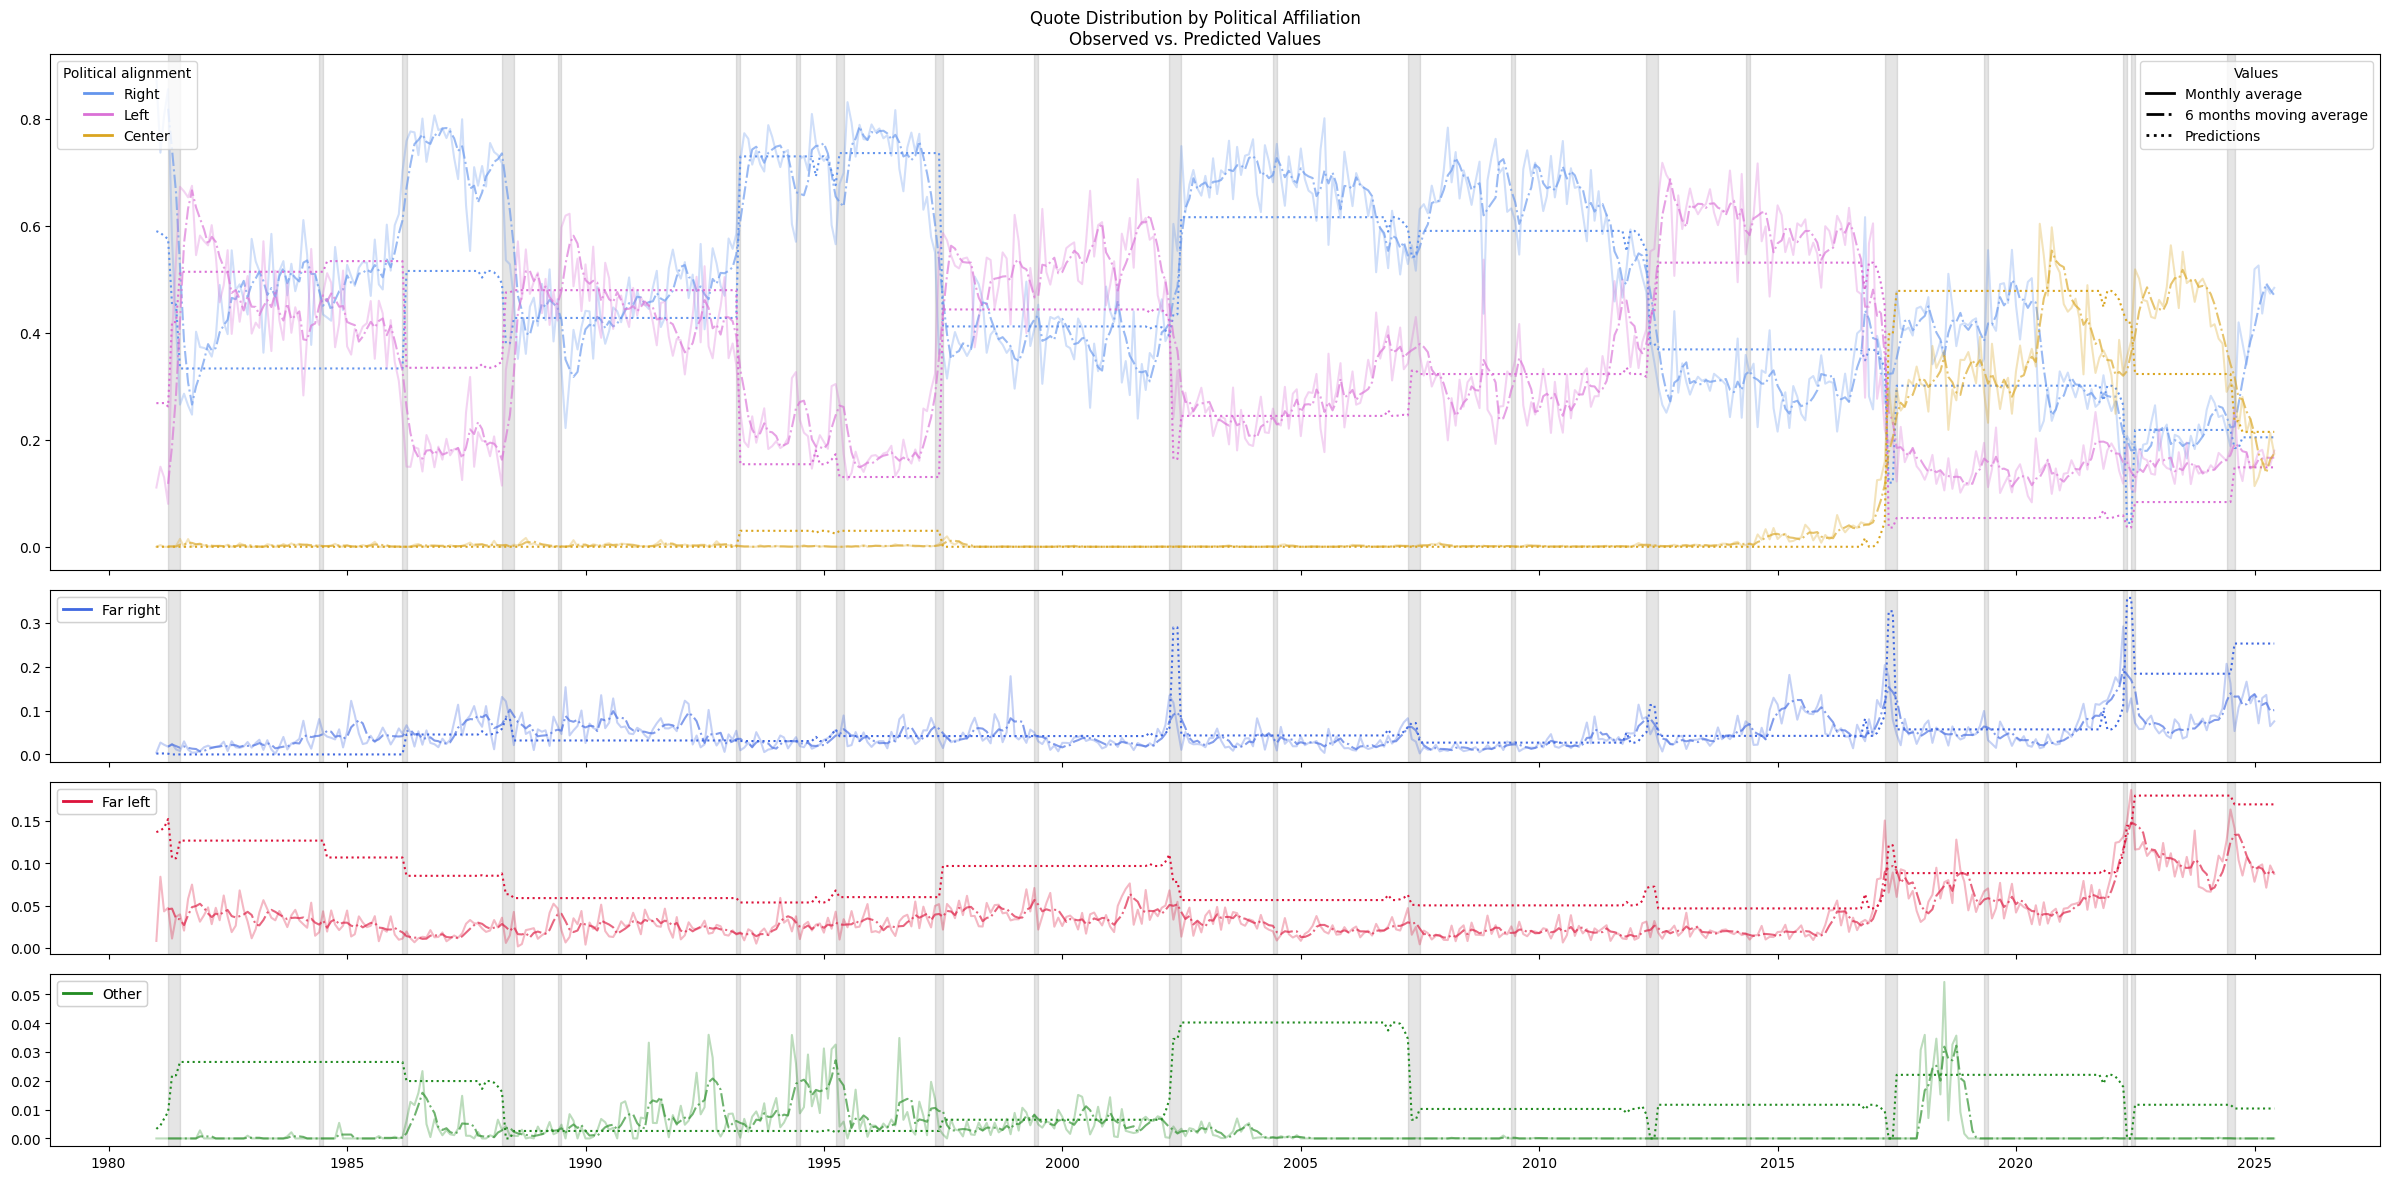

In [18]:
alignment_groups = [
    (['Right', 'Left', 'Center'],
     {'Right': 'cornflowerblue',
      'Left': 'orchid',
      'Center': 'goldenrod'}),
    (['Far right'],
     {'Far right': 'royalblue'}),
    (['Far left'],
     {'Far left': 'crimson'}),
    (['Other'],
     {'Other': 'forestgreen'})]

fig, axes = plt.subplots(
    4, 1, figsize=(24, 12), sharex=True,
    gridspec_kw={'height_ratios': [3, 1, 1, 1]}
)

for ax, (political_alignments, colors) in zip(axes, alignment_groups):
    alignment_handles = []

    for alignment in political_alignments:
        subset_data = plot_data[plot_data['political_alignment'] == alignment].copy()
        subset_data['MA'] = subset_data[outcome].rolling(window=4).mean()
        
        ax.plot(subset_data['month'], subset_data[outcome], label=None,
                alpha=0.3, color=colors[alignment], linestyle='-')
        ax.plot(subset_data['month'], subset_data['MA'], label=None,
                alpha=0.65, color=colors[alignment], linestyle='dashdot')
        ax.plot(subset_data['month'], subset_data['y_norm'], label=None,
                alpha=1, color=colors[alignment], linestyle='dotted')
        
        alignment_handles.append(Line2D([0], [0], color=colors[alignment], lw=2, label=alignment))

    if political_alignments == ['Right', 'Left', 'Center']:
        alignment_legend = ax.legend(handles=alignment_handles, title="Political alignment", loc="upper left")
        ax.add_artist(alignment_legend)
        
        line_type_handles = [
            Line2D([0], [0], color='black', lw=2, linestyle='-', label="Monthly average"),
            Line2D([0], [0], color='black', lw=2, linestyle='dashdot', label="6 months moving average"),
            Line2D([0], [0], color='black', lw=2, linestyle='dotted', label="Predictions")]
        ax.legend(handles=line_type_handles, title="Values", loc="upper right")

    else:
        alignment_legend = ax.legend(handles=alignment_handles, title="", loc="upper left")
        ax.add_artist(alignment_legend)
        
axes[-1].set_xlabel("")

add_shaded_periods(axes, main_elec_months, color='black', alpha=0.1)

plt.suptitle("Quote Distribution by Political Affiliation\nObserved vs. Predicted Values")
plt.tight_layout()
plt.savefig("output/nuances_val_graph.png", dpi=300, bbox_inches='tight')
plt.show()

## 2.3. Résidus relatifs

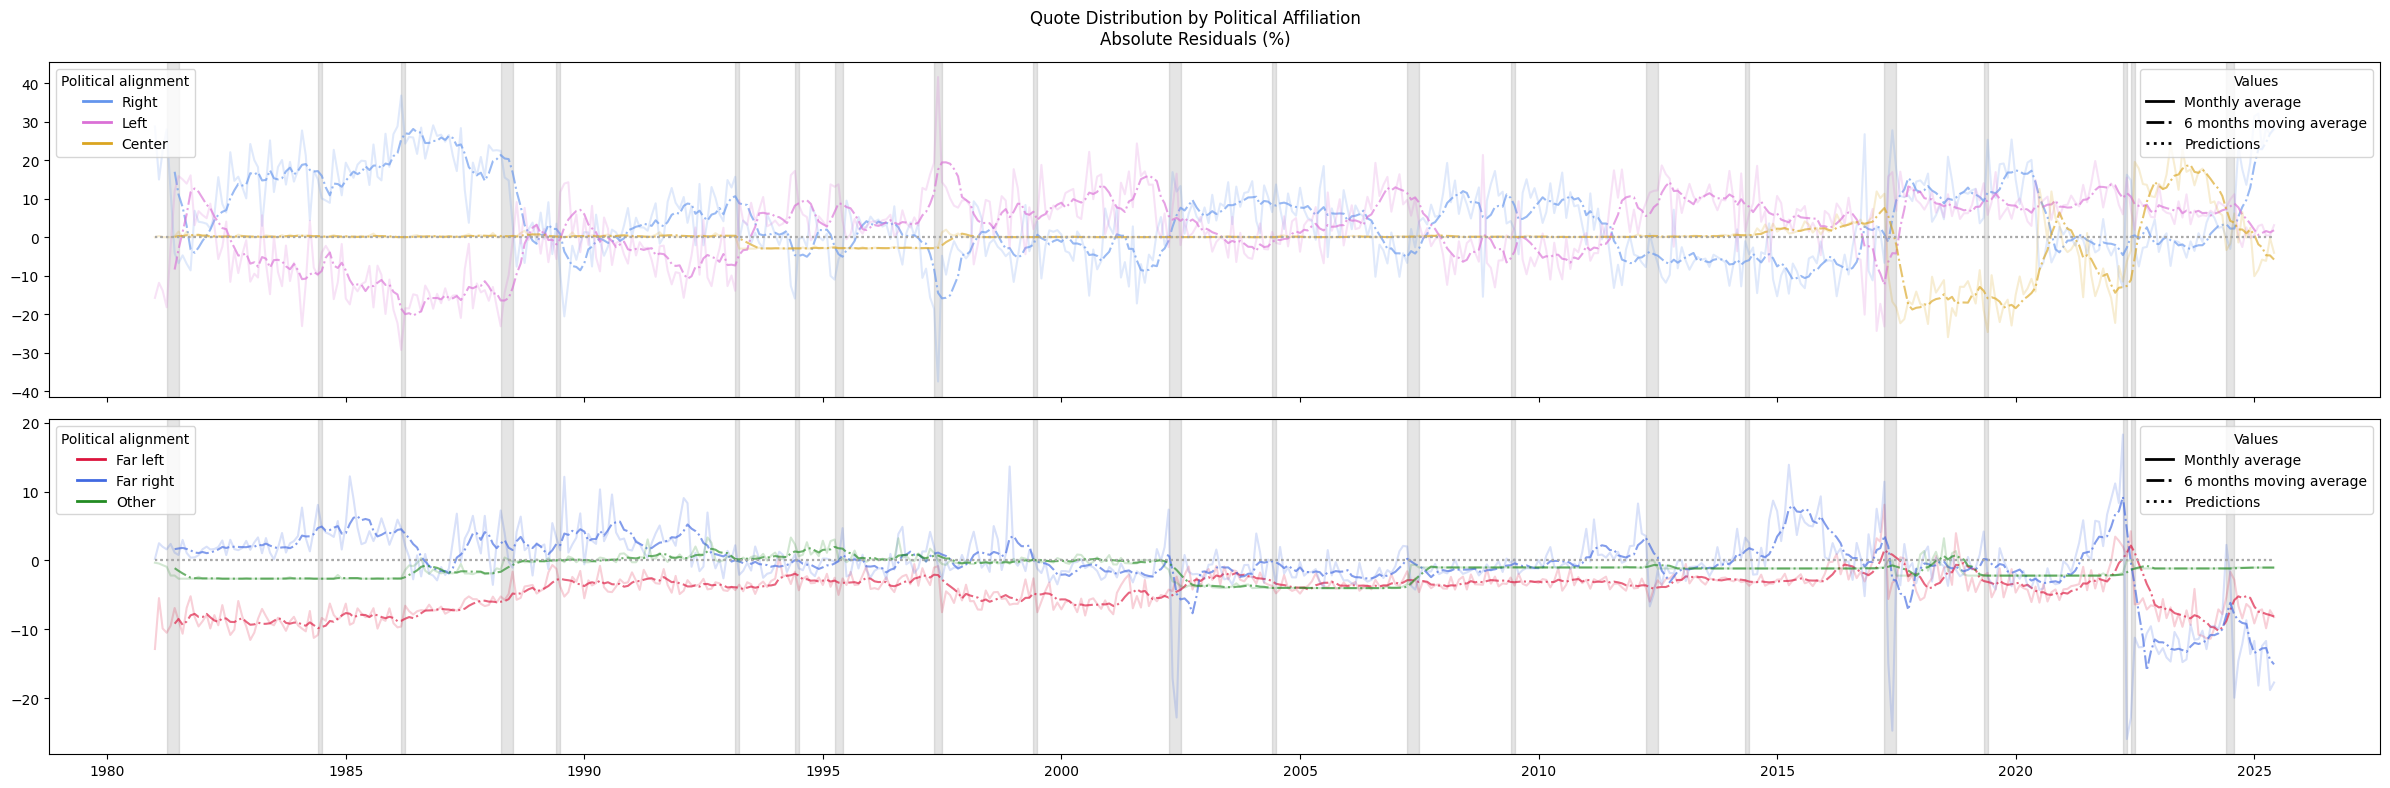

In [19]:
alignment_groups = [
    (['Right', 'Left', 'Center'],
     {'Right': 'cornflowerblue',
      'Left': 'orchid',
      'Center': 'goldenrod'}),
    (['Far left', 'Far right', 'Other'],
     {'Far left': 'crimson',
      'Far right': 'royalblue',
      'Other': 'forestgreen'})]

fig, axes = plt.subplots(2, 1, figsize=(24, 8), sharex=True)

for ax, (political_alignments, colors) in zip(axes, alignment_groups):
    alignment_handles = []

    for alignment in political_alignments:
        subset_data = plot_data[plot_data['political_alignment'] == alignment].copy()
        subset_data['MA'] = subset_data['abs_residuals'].rolling(window=6).mean()
        
        ax.plot(subset_data['month'], subset_data['abs_residuals'], label=None,
                alpha=0.2, color=colors[alignment], linestyle='-')
        ax.plot(subset_data['month'], subset_data['MA'], label=None,
                alpha=0.65, color=colors[alignment], linestyle='-.')
        ax.plot(subset_data['month'], [0] * len(subset_data), label=None,
                alpha=1, color='darkgray', linestyle=':')
        
        alignment_handles.append(Line2D([0], [0], color=colors[alignment], lw=2, label=alignment))

    alignment_legend = ax.legend(handles=alignment_handles, title="Political alignment", loc="upper left")
    ax.add_artist(alignment_legend)

    line_type_handles = [
        Line2D([0], [0], color='black', lw=2, linestyle='-', label="Monthly average"),
        Line2D([0], [0], color='black', lw=2, linestyle='-.', label="6 months moving average"),
        Line2D([0], [0], color='black', lw=2, linestyle=':', label="Predictions")
    ]
    ax.legend(handles=line_type_handles, title="Values", loc="upper right")

axes[-1].set_xlabel("")

add_shaded_periods(axes, main_elec_months, color='black', alpha=0.1)

plt.suptitle("Quote Distribution by Political Affiliation\nAbsolute Residuals (%)")
plt.tight_layout()
plt.savefig("output/nuances_res_graph.png", dpi=300, bbox_inches='tight')
plt.show()

## 2.4. Matrice de confusion

In [20]:
def compute_proportional_metrics(y_norm, y_true):
    y_norm = np.array(y_norm)
    y_true = np.array(y_true)
    
    # Initialize arrays
    TP = np.zeros_like(y_norm)
    TN = np.zeros_like(y_norm)
    FP = np.zeros_like(y_norm)
    FN = np.zeros_like(y_norm)
    
    # Calculate difference
    diff = y_norm - y_true
    
    # Case 1: y_norm - y_true = 0 (perfect prediction)
    perfect_mask = (diff == 0)
    TP[perfect_mask] = 1
    FP[perfect_mask] = 0
    FN[perfect_mask] = 0
    
    # Case 2: y_norm - y_true > 0 (over-prediction)
    over_mask = (diff > 0)
    TP[over_mask] = y_true[over_mask] / y_norm[over_mask]
    FP[over_mask] = diff[over_mask] / y_norm[over_mask]
    FN[over_mask] = 0
    
    # Case 3: y_norm - y_true < 0 (under-prediction)
    under_mask = (diff < 0)
    TP[under_mask] = 1
    FN[under_mask] = - diff[under_mask] / y_true[under_mask]
    FP[under_mask] = 0
    
    return {
        'TP': TP.mean(),
        'FP': FP.mean(),
        'FN': FN.mean()}

In [21]:
results = []

for period_label, period_filter in {
    '1981-2009': model_data_njl["month"] <= cutoff,
    '2010-2025': model_data_njl["month"] > cutoff
}.items():
    period_data = model_data_njl[period_filter]
    
    for alignment in period_data["political_alignment"].unique():

        subset_data = period_data[period_data["political_alignment"] == alignment]
        y = subset_data[outcome]
        y_norm = subset_data['y_norm']
        mr = (y - y_norm).mean()
        metrics = compute_proportional_metrics(y_norm, y)
        results.append({
            'period': period_label,
            'alignment': alignment,
            'mean residuals': mr,
            '% correct predictions': 100 * metrics['TP'],
            '% excess predictions': 100 * metrics['FP'],
            '% missing predictions': 100 * metrics['FN']})

summary = pd.DataFrame(results)
summary["alignment"] = pd.Categorical(summary["alignment"], categories=nuances_order, ordered=True)
summary_tbl = summary.pivot_table(index="alignment",
                                    columns="period",
                                    values=["% correct predictions",
                                            "% excess predictions",
                                            "% missing predictions"],
                                    observed=False)
summary_tbl = summary_tbl.reset_index()
summary_tbl.columns.names = [None, None]
summary_tbl.style.hide(axis="index").format({col: "{:.1f}" for col in summary_tbl.columns[1:]})

Ce tableau présente les proportions des proportions de citations correctement prédites. Les valeurs s'interprètent comme les différences entre les courbes des valeurs prédites et réelles.
- Correct predictions = proportion des citations prédites correspondant à des citations réelles (lorsque la courbe des citations prédites est <= à celle des citations réelles)
- Excess predictions = proportion des citations prédites excédant les citations réelles (lorsque la courbe des citations prédites est >= à celle des citations réelles)
- Missing predictions = proportion des citations réelles non-prédites par le modèle (lorsque la courbe des citations réelles est >= à celle des citations prédites)

## 2.5. Régressions
Pour une analyse plus rigoureuse, on peut régresser les résidus sur nos variables d'intérêt.

In [22]:
plot_data['month'] = plot_data['month'].dt.to_period('M')
plot_data["period"] = pd.NA

plot_data.loc[plot_data["month"] <= cutoff, "period"] = "1981-2009"
plot_data.loc[plot_data["month"] > cutoff, "period"] = "2010-2025"

### a. Nuances politiques + périodes

In [23]:
alignment_ref = 'Far right'
period_ref = '1981-2009'

model = smf.ols(
    "Q('abs_residuals') ~ C(political_alignment,Treatment(reference='{}')) + C(period, Treatment(reference='{}'))".format(alignment_ref, period_ref),
    data=plot_data
).fit(covtype='HC3')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Q('abs_residuals')   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     89.31
Date:                Mon, 29 Sep 2025   Prob (F-statistic):          6.96e-104
Time:                        22:40:46   Log-Likelihood:                -10674.
No. Observations:                3204   AIC:                         2.136e+04
Df Residuals:                    3197   BIC:                         2.141e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================================================================
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                               -0.3485      0.306     -1.138      0.255      -0.949       0.252
C(political_alignment, Treatment(reference='Far right'))[T.Center]      -0.3723      0.415     -0.897      0.370      -1.186       0.441
C(political_alignment, Treatment(reference='Far right'))[T.Far left]    -4.0301      0.415     -9.715      0.000      -4.844      -3.217
C(political_alignment, Treatment(reference='Far right'))[T.Left]         2.4895      0.415      6.001      0.000       1.676       3.303
C(political_alignment, Treatment(reference='Far right'))[T.Other]       -0.8482      0.415     -2.045      0.041      -1.662      -0.035
C(political_alignment, Treatment(reference='Far right'))[T.Right]        4.8519      0.415     11.696      0.000       4.039       5.665
C(period, Treatment(reference='1981-2009'))[T.2010-2025]                 0.0001      0.251      0.001      1.000      -0.493       0.493
==============================================================================
Omnibus:                      285.274   Durbin-Watson:                   2.236
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1664.900
Skew:                          -0.186   Prob(JB):                         0.00
Kurtosis:                       6.512   Cond. No.                         7.29
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
mr_right = plot_data[plot_data['political_alignment'] == 'Far right']['abs_residuals'].mean()
mr_left = plot_data[plot_data['political_alignment'] == 'Left']['abs_residuals'].mean()
diff = mr_left - mr_right

print(f"Mean residuals for the far right: {mr_right:.4f}")
print(f"Mean residuals for the left: {mr_left:.4f}")
print(f"Difference between residuals for the left and the right: {diff:.4f}")

Mean residuals for the far right: -0.3485
Mean residuals for the left: 2.1410
Difference between residuals for the left and the right: 2.4895


In [25]:
mr_right = plot_data[plot_data['political_alignment'] == 'Far right']['abs_residuals'].mean()
mr_left = plot_data[plot_data['political_alignment'] == 'Far left']['abs_residuals'].mean()
diff = mr_left - mr_right

print(f"Mean residuals for the far right: {mr_right:.4f}")
print(f"Mean residuals for the far left: {mr_left:.4f}")
print(f"Difference between residuals for the left and the right: {diff:.4f}")

Mean residuals for the far right: -0.3485
Mean residuals for the far left: -4.3786
Difference between residuals for the left and the right: -4.0301


Pour `C(political_alignment, Treatment(reference='Far right'))[T.Left]`, le coefficient est de 2,4895. Cela signifie que les résidus moyens de la gauche sont supérieurs de 2,4895 points de pourcentage à ceux de la droite, en moyenne sur l'ensemble des périodes.
- Les résidus moyens de l'extrême droite valent -0,3485 : en moyenne, la proportion des citations des personnalités de droite est inférieure de 0,3485 pp à celle prédite par le modèle, ce qui signifie que l'extrême droite est désavantagée par rapport à la norme de représentativité.
- Les résidus moyens de la gauche valent 2,1410 : en moyenne, la proportion des citations des personnalités de gauche est supérieure de 2,1410 pp à celle prédite par le modèle, ce qui signifie que la gauche est avantagée.
- La différence entre ces deux valeurs est de 2,4895 : la gauche est avantagée par rapport à la droite, à hauteur de 2,4895 pp.

Dans le cas de l'extrême gauche, cette différence est négative : l'extrême gauche est désavantagée par rapport à l'extrême droite, à hauteur de 4,0301 pp. Comme ses résidus moyens sont négatifs, elle est désavantagée aussi dans l'absolu.

### b. Nuances politiques * périodes

In [26]:
alignment_ref = 'Far right'
period_ref = '1981-2009'

model = smf.ols(
    "Q('abs_residuals') ~ C(political_alignment,Treatment(reference='{}')) * C(period, Treatment(reference='{}'))".format(alignment_ref, period_ref),
    data=plot_data
).fit(covtype='HC3')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Q('abs_residuals')   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     65.60
Date:                Mon, 29 Sep 2025   Prob (F-statistic):          1.33e-132
Time:                        22:40:46   Log-Likelihood:                -10596.
No. Observations:                3204   AIC:                         2.122e+04
Df Residuals:                    3192   BIC:                         2.129e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================================================================================
                                                                                                                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                                         0.5359      0.355      1.510      0.131      -0.160       1.232
C(political_alignment, Treatment(reference='Far right'))[T.Center]                                                               -0.7938      0.502     -1.582      0.114      -1.778       0.190
C(political_alignment, Treatment(reference='Far right'))[T.Far left]                                                             -5.3656      0.502    -10.691      0.000      -6.350      -4.382
C(political_alignment, Treatment(reference='Far right'))[T.Left]                                                                 -0.4995      0.502     -0.995      0.320      -1.484       0.484
C(political_alignment, Treatment(reference='Far right'))[T.Other]                                                                -1.6988      0.502     -3.385      0.001      -2.683      -0.715
C(political_alignment, Treatment(reference='Far right'))[T.Right]                                                                 5.1421      0.502     10.246      0.000       4.158       6.126
C(period, Treatment(reference='1981-2009'))[T.2010-2025]                                                                         -2.5389      0.601     -4.222      0.000      -3.718      -1.360
C(political_alignment, Treatment(reference='Far right'))[T.Center]:C(period, Treatment(reference='1981-2009'))[T.2010-2025]       1.2100      0.850      1.423      0.155      -0.457       2.877
C(political_alignment, Treatment(reference='Far right'))[T.Far left]:C(period, Treatment(reference='1981-2009'))[T.2010-2025]     3.8339      0.850      4.509      0.000       2.167       5.501
C(political_alignment, Treatment(reference='Far right'))[T.Left]:C(period, Treatment(reference='1981-2009'))[T.2010-2025]         8.5814      0.850     10.091      0.000       6.914      10.249
C(political_alignment, Treatment(reference='Far right'))[T.Other]:C(period, Treatment(reference='1981-2009'))[T.2010-2025]        2.4422      0.850      2.872      0.004       0.775       4.110
C(political_alignment, Treatment(reference='Far right'))[T.Right]:C(period, Treatment(reference='1981-2009'))[T.2010-2025]       -0.8330      0.850     -0.980      0.327      -2.500       0.834
==============================================================================
Omnibus:                      302.555   Durbin-Watson:                   2.220
Prob(Omnibus): 

In [27]:
mr_right_8102 = plot_data[(plot_data['political_alignment'] == 'Far right') & (plot_data['period'] == '1981-2009')]['abs_residuals'].mean()
mr_left_8102 = plot_data[(plot_data['political_alignment'] == 'Left') & (plot_data['period'] == '1981-2009')]['abs_residuals'].mean()
mr_right_1724 = plot_data[(plot_data['political_alignment'] == 'Far right') & (plot_data['period'] == '2010-2025')]['abs_residuals'].mean()
mr_left_1724 = plot_data[(plot_data['political_alignment'] == 'Left') & (plot_data['period'] == '2010-2025')]['abs_residuals'].mean()

print("Intercept")
print(f"{mr_right_8102:.4f}")
print("C(period, Treatment(reference='1981-2009'))[T.2010-2025]")
print(f"{(mr_right_1724 - mr_right_8102):.4f}")
print("C(political_alignment, Treatment(reference='Far right'))[T.Left]")
print(f"{(mr_left_8102 - mr_right_8102):.4f}")
print("C(political_alignment, Treatment(reference='Far right'))[T.Left]:C(period, Treatment(reference='1981-2009'))[T.2010-2025]")
print(f"{(mr_left_1724 - mr_right_1724) - (mr_left_8102 - mr_right_8102):.4f}")

Intercept
0.5359
C(period, Treatment(reference='1981-2009'))[T.2010-2025]
-2.5389
C(political_alignment, Treatment(reference='Far right'))[T.Left]
-0.4995
C(political_alignment, Treatment(reference='Far right'))[T.Left]:C(period, Treatment(reference='1981-2009'))[T.2010-2025]
8.5814


# 3. Écarts à la norme de représentativité selon les journaux

In [28]:
model_data['y_norm'] = compute_y_pred(
    model_data,
    n, alpha, beta, gamma, theta,
    delta_pre_5, delta_pre_4, delta_pre_3, delta_pre_2, delta_pre_1, delta_pre_0,
    lambda_1, lambda_2)
plot_data = model_data.copy()
plot_data['abs_residuals'] = 100 * (plot_data[outcome] - plot_data['y_norm'])

## 3.1. Résidus moyens

In [29]:
first_period = (
    plot_data[plot_data["month"] <= cutoff]
    .groupby('journal')["abs_residuals"].mean()
    .rename("1981-2009")
)

second_period = (
    plot_data[plot_data["month"] > cutoff]
    .groupby('journal')["abs_residuals"].mean()
    .rename("2010-2025")
)

both_periods = (
    plot_data.groupby('journal')["abs_residuals"].mean()
    .rename("1981-2025")
)

mr_table = pd.concat([first_period, second_period, both_periods], axis=1)
mr_table.style.format("{:.4f}")

## 3.5. Régressions

In [30]:
# plot_data['month'] = plot_data['month'].dt.to_period('M')
plot_data["period"] = pd.NA

plot_data.loc[plot_data["month"] <= cutoff, "period"] = "1981-2009"
plot_data.loc[plot_data["month"] > cutoff, "period"] = "2010-2025"

In [31]:
journal_ref = 'Le Monde'
period_ref = '1981-2009'

model = smf.ols(
    "Q('abs_residuals') ~ C(journal, Treatment(reference='{}')) * C(period, Treatment(reference='{}'))".format(journal_ref, period_ref),
    data=plot_data
).fit(covtype='HC3')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Q('abs_residuals')   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                 1.451e-07
Date:                Mon, 29 Sep 2025   Prob (F-statistic):               1.00
Time:                        22:40:46   Log-Likelihood:                -43075.
No. Observations:               12312   AIC:                         8.617e+04
Df Residuals:                   12302   BIC:                         8.624e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================================================================================================================
                                                                                                                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                          -3.586e-05      0.175     -0.000      1.000      -0.343       0.343
C(journal, Treatment(reference='Le Monde'))[T.La Croix]                                                             9.915e-05      0.269      0.000      1.000      -0.526       0.526
C(journal, Treatment(reference='Le Monde'))[T.Le Figaro]                                                            1.818e-14      0.248   7.34e-14      1.000      -0.486       0.486
C(journal, Treatment(reference='Le Monde'))[T.Libération]                                                           -5.08e-05      0.324     -0.000      1.000      -0.635       0.635
C(journal, Treatment(reference='Le Monde'))[T.Médiapart]                                                              -0.0003      0.690     -0.000      1.000      -1.352       1.352
C(period, Treatment(reference='1981-2009'))[T.2010-2025]                                                               0.0001      0.297      0.000      1.000      -0.582       0.582
C(journal, Treatment(reference='Le Monde'))[T.La Croix]:C(period, Treatment(reference='1981-2009'))[T.2010-2025]   -9.915e-05      0.432     -0.000      1.000      -0.848       0.847
C(journal, Treatment(reference='Le Monde'))[T.Le Figaro]:C(period, Treatment(reference='1981-2009'))[T.2010-2025]  -4.247e-14      0.420  -1.01e-13      1.000      -0.823       0.823
C(journal, Treatment(reference='Le Monde'))[T.Libération]:C(period, Treatment(reference='1981-2009'))[T.2010-2025]   5.08e-05      0.469      0.000      1.000      -0.919       0.919
C(journal, Treatment(reference='Le Monde'))[T.Médiapart]:C(period, Treatment(reference='1981-2009'))[T.2010-2025]      0.0003      0.768      0.000      1.000      -1.506       1.507
==============================================================================
Omnibus:                     1589.884   Durbin-Watson:                   2.239
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5876.205
Skew:                           0.623   Prob(JB):                         0.00
Kurtosis:                       6.147   Cond. No.                         17.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 4. Ecarts journaux * nuances politiques * *périodes*

In [32]:
plot_data_p1 = plot_data[plot_data["month"] <= cutoff]
plot_data_p2 = plot_data[plot_data["month"] > cutoff]

## 4.1. Résidus moyens

In [33]:
# Reference period
mr_table = plot_data_p1.groupby(['political_alignment', 'journal'])['abs_residuals'].mean().unstack()
mr_table = mr_table.reindex(nuances_order)
mr_table.style.format("{:.4f}")

In [34]:
# Test period
mr_table = plot_data_p2.groupby(['political_alignment', 'journal'])['abs_residuals'].mean().unstack()
mr_table = mr_table.reindex(nuances_order)
mr_table.style.format("{:.4f}")

## 4.2. Observations vs. prédictions

In [35]:
plot_data['month'] = plot_data['month'].dt.to_timestamp()

In [36]:
colors = {
    'Le Figaro': 'mediumblue',
    'Libération': 'tomato',
    'Le Monde': 'dimgrey',
    'La Croix': 'goldenrod',
    'Médiapart': 'limegreen'}

alignments = [
    "Far right",
    "Right",
    "Center",
    "Left",
    "Far left"]

n_alignments = len(alignments)

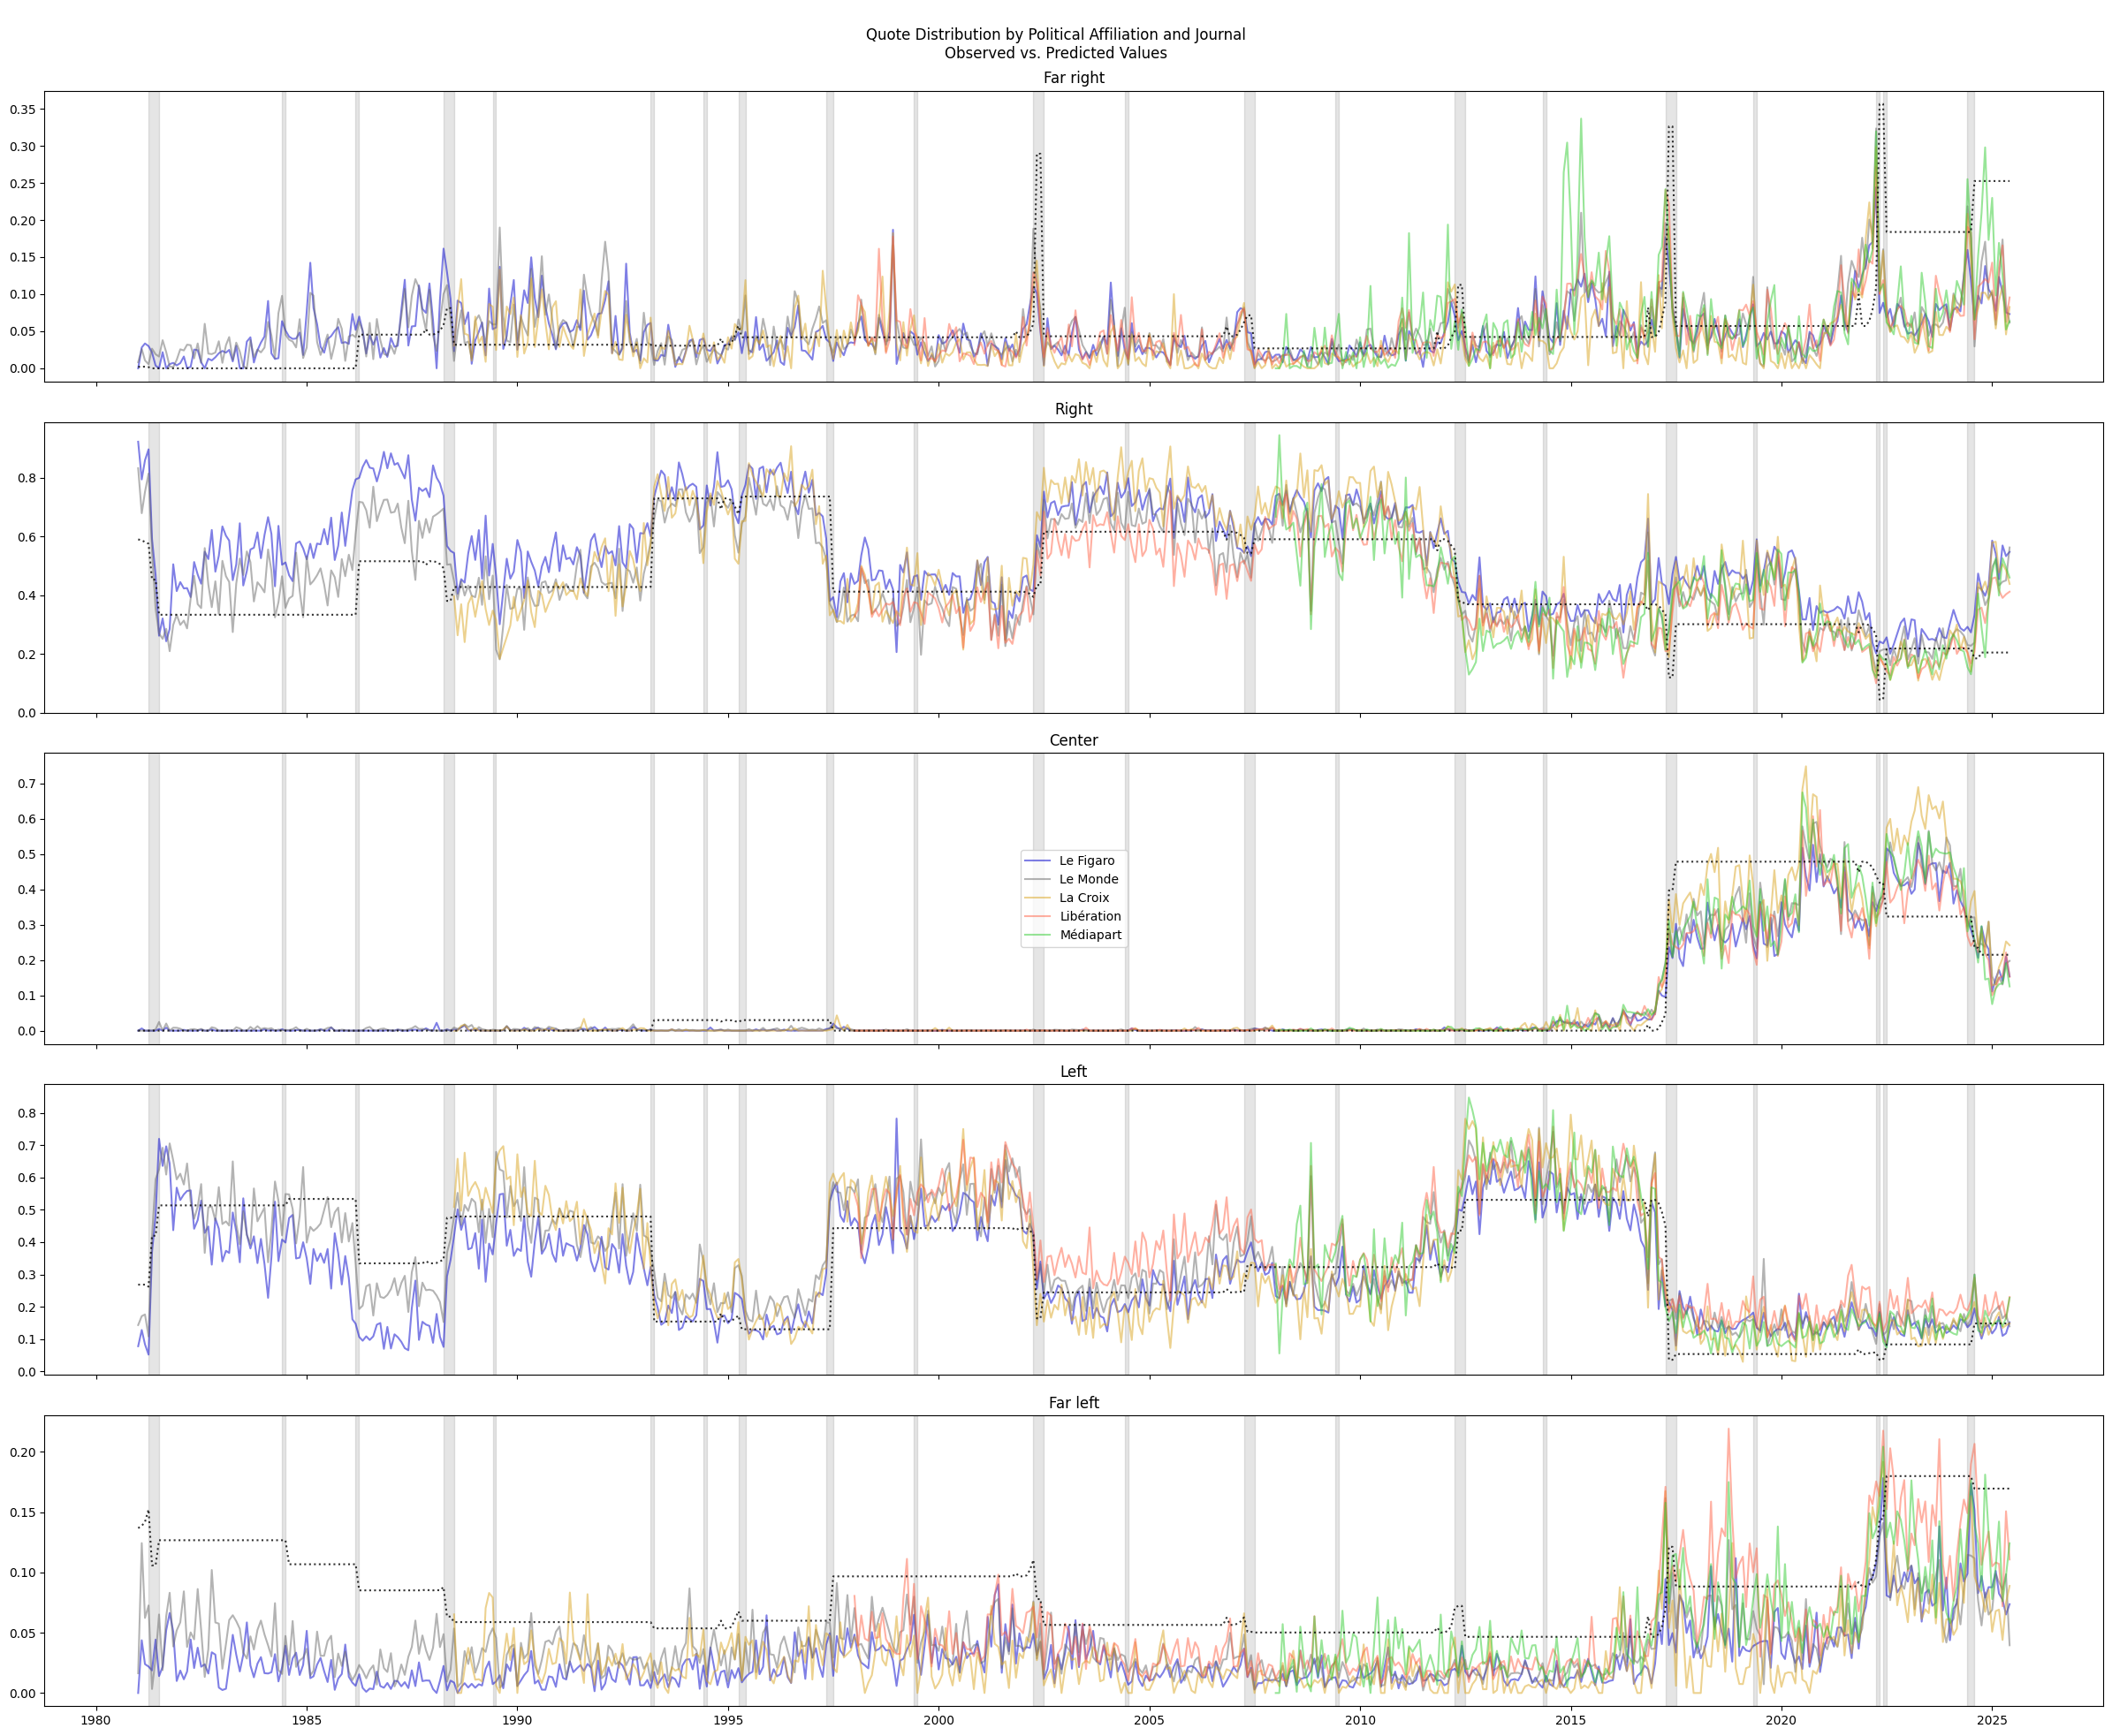

In [37]:
fig, axes = plt.subplots(n_alignments, 1, figsize=(24, 4 * n_alignments), sharex=True)

for i, alignment in enumerate(alignments):
    ax = axes[i]
    subset_data = plot_data[plot_data['political_alignment'] == alignment]

    for journal in subset_data['journal'].unique():
        sub_subset_data = subset_data[subset_data['journal'] == journal].copy()
        sub_subset_data['MA'] = sub_subset_data[outcome].rolling(window=12).mean()
        ax.plot(sub_subset_data['month'], sub_subset_data[outcome], label=journal,
                alpha=0.5, color=colors[journal], linestyle='-')

    ax.plot(subset_data['month'], subset_data['y_norm'], color='black', alpha=0.8, linestyle='dotted')
    ax.set_title(f"{alignment}")
    if i == 2:
        ax.legend(title="", loc="center")

add_shaded_periods(axes, main_elec_months, color='black', alpha=0.1)

plt.suptitle("""
Quote Distribution by Political Affiliation and Journal
Observed vs. Predicted Values
""")
plt.tight_layout()
plt.savefig("output/journals_val_graph.png", dpi=300, bbox_inches='tight')
plt.show()

## 4.3. Résidus relatifs

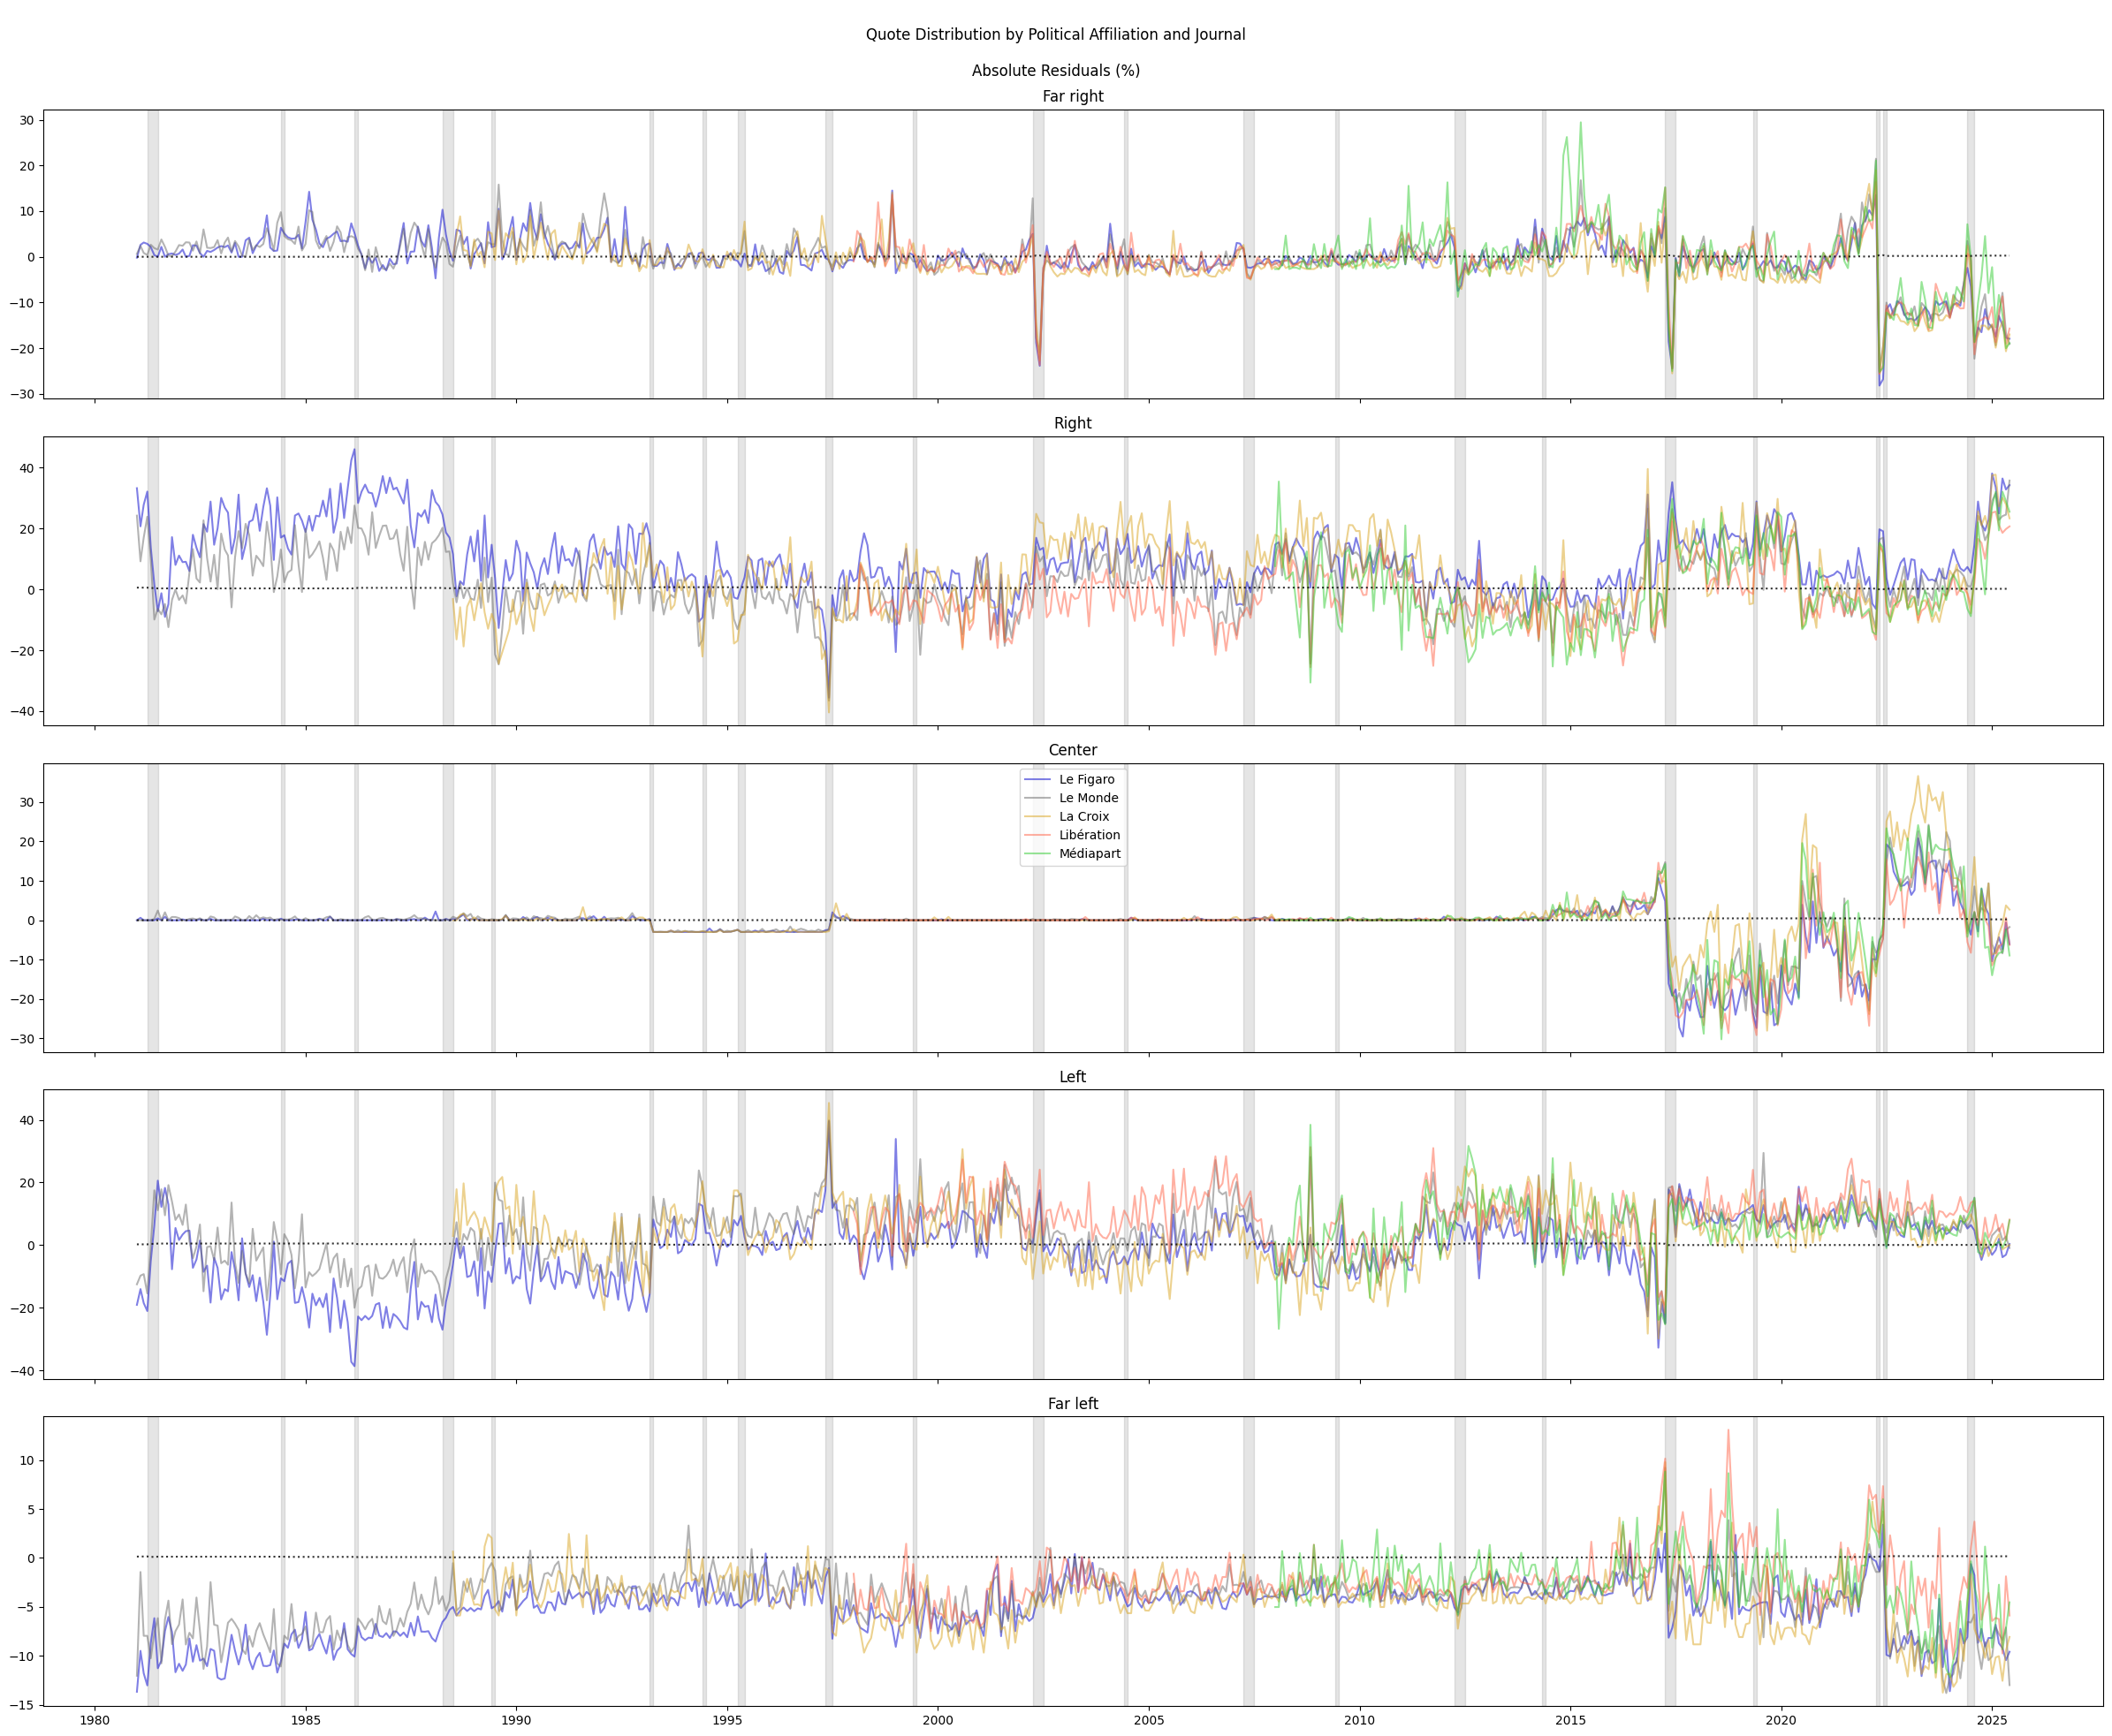

In [38]:
fig, axes = plt.subplots(n_alignments, 1, figsize=(24, 4 * n_alignments), sharex=True)

for i, alignment in enumerate(alignments):
    ax = axes[i]
    subset_data = plot_data[plot_data['political_alignment'] == alignment]

    for journal in subset_data['journal'].unique():
        sub_subset_data = subset_data[subset_data['journal'] == journal].copy()
        sub_subset_data['MA'] = sub_subset_data['abs_residuals'].rolling(window=12).mean()
        ax.plot(sub_subset_data['month'], sub_subset_data['abs_residuals'], label=journal,
                alpha=0.5, color=colors[journal], linestyle='-')

    ax.plot(subset_data['month'], subset_data['y_norm'], color='black', alpha=0.8, linestyle='dotted')
    ax.set_title(f"{alignment}")
    if i == 2:
        ax.legend(title="", loc="upper center")

add_shaded_periods(axes, main_elec_months, color='black', alpha=0.1)

plt.suptitle("""
Quote Distribution by Political Affiliation and Journal\n
Absolute Residuals (%)
""")
plt.tight_layout()
plt.savefig("output/journals_res_graph.png", dpi=300, bbox_inches='tight')
plt.show()

## 4.4. Matrice de confusion

In [39]:
results = []

for period_label, period_filter in {
    '1981-2000': model_data["month"] <= cutoff,
    '2010-2025': model_data["month"] > cutoff
}.items():
    period_data = model_data[period_filter]
    
    for alignment in period_data["political_alignment"].unique():
        subset_data = period_data[period_data["political_alignment"] == alignment]
        
        for journal in subset_data["journal"].unique():
            sub_subset_data = subset_data[subset_data["journal"] == journal]
            y = sub_subset_data[outcome]
            y_norm = sub_subset_data['y_norm']
            mr = (y - y_norm).mean()
            metrics = compute_proportional_metrics(y_norm, y)
            results.append({
                'period': period_label,
                'alignment': alignment,
                'journal': journal,
                'mean residuals': mr,
                '% correct predictions': 100 * metrics['TP'],
                '% excess predictions': 100 * metrics['FP'],
                '% missing predictions': 100 * metrics['FN']})

        

summary = pd.DataFrame(results)
summary["alignment"] = pd.Categorical(summary["alignment"], categories=nuances_order, ordered=True)
summary_tbl = summary.pivot_table(index=(["alignment", "journal"]),
                                    columns="period",
                                    values=["% correct predictions",
                                            "% excess predictions",
                                            "% missing predictions"],
                                    observed=False)
summary_tbl = summary_tbl.reset_index()
summary_tbl.columns.names = [None, None]
summary_tbl.style.hide(axis="index").format({col: "{:.3f}" for col in summary_tbl.columns[2:]})

## 4.5. Régressions - seconde période seulement

In [40]:
model = smf.ols(
    "Q('abs_residuals') ~ C(political_alignment,Treatment(reference='{}')) * C(journal, Treatment(reference='{}'))".format(alignment_ref, journal_ref, period_ref),
    data=plot_data_p2
).fit(covtype='HC3')
model.summary().tables[0]

<class 'statsmodels.iolib.table.SimpleTable'>

In [41]:
alpha = 0.01
p_values = model.pvalues
significant_count = (p_values <= alpha).sum()

print(f"Number of significant coefficients: {significant_count}")
print(f"Share of significant coefficients: {significant_count / len(p_values):.1%}")

Number of significant coefficients: 8
Share of significant coefficients: 26.7%


In [42]:
df = model.summary2().tables[1]
df = df[df['P>|t|'] <= alpha]
df.style.format("{:.4f}")